# Transfer learning
---
In this module, we will
 - analyze resnet nerural network architecture
 - make predictions over random images with resnet pretrained on ImageNet dataset (***http://www.image-net.org/***)
 - create your own dataset
 - finetune resnet for our custom dataset


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

---

## Introduction to Resnet18

### Architecture
PyTorch tooling related to image processing can be found in `torchvision` module. Information about accessible pretrained models for PyTorch can be found at ***https://pytorch.org/docs/stable/torchvision/models.html***.

In [2]:
from torchvision import models

In [3]:
resnet18 = models.resnet18()
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [4]:
conv1 = resnet18.layer4[0].conv1
conv1

Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)

### Prediction with pretrained model

In [5]:
from image_processing_workshop.utils import get_image_from_url
from image_processing_workshop.visual import plot_image
from torchvision import datasets, transforms
import numpy as np
import os
import torch

In [6]:
# Default path where to save pretrained models.
os.environ["TORCH_HOME"] = "./"

In [7]:
models.resnet.model_urls

{'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
 'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
 'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
 'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
 'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth'}

In [8]:
resnet18 = models.resnet18(pretrained=True)
info = resnet18.eval()

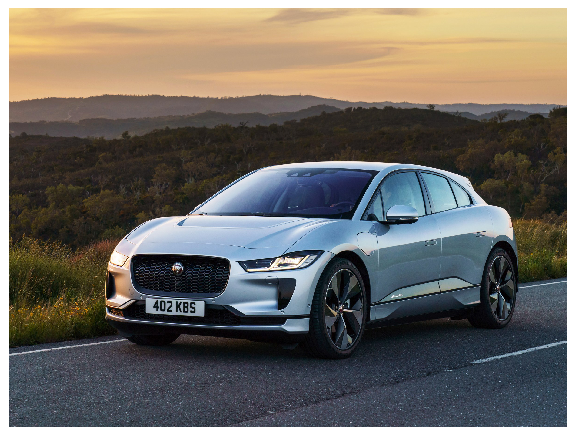

In [9]:
url = 'https://media.wired.com/photos/5b86fce8900cb57bbfd1e7ee/master/pass/Jaguar_I-PACE_S_Indus-Silver_065.jpg'
img = get_image_from_url(url)
plot_image(img)

In [10]:
# Transformation for resnet, normalization is important!!
transformation = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [11]:
transformed_img = transformation(img)

In [12]:
img.shape, transformed_img.shape

((1800, 2400, 3), torch.Size([3, 224, 298]))

In [13]:
batch = transformed_img.unsqueeze(0)
resnet18(batch)[0][:10]

tensor([-1.0964, -2.3460, -0.1128, -1.9760, -1.0110, -1.7371, -1.0038, -0.4055,
        -0.7152,  0.5701], grad_fn=<SliceBackward>)

In [14]:
# Let's adjust last layer and add softmax, softmax doesn't need training, it's just normalization.
resnet18.fc = torch.nn.Sequential(
    resnet18.fc, 
    torch.nn.Softmax(dim=1))

In [15]:
resnet18(batch)[0][:10]

tensor([1.1077e-05, 3.1749e-06, 2.9622e-05, 4.5964e-06, 1.2065e-05, 5.8367e-06,
        1.2152e-05, 2.2105e-05, 1.6217e-05, 5.8641e-05],
       grad_fn=<SliceBackward>)

In [16]:
from image_processing_workshop.utils import get_imagenet_category_names
from image_processing_workshop.visual import plot_classify

In [17]:
get_imagenet_category_names(use_cache=True)[:10]

['tench',
 'goldfish',
 'great_white_shark',
 'tiger_shark',
 'hammerhead',
 'electric_ray',
 'stingray',
 'cock',
 'hen',
 'ostrich']

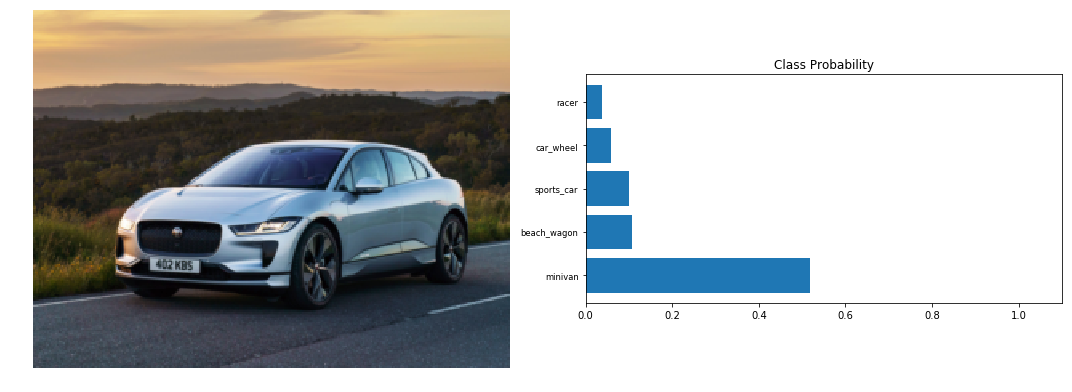

In [19]:
plot_classify(transformed_img, resnet18, topn=5, category_names=get_imagenet_category_names(), figsize=(15,15))

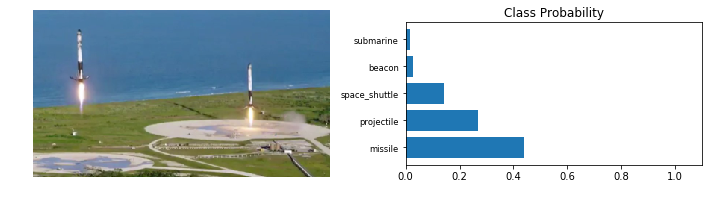

In [20]:
url = 'https://s.w-x.co/util/image/w/411spacex.jpg?v=at&w=815&h=458'
img = get_image_from_url(url)
transformed_img = transformation(img)
plot_classify(transformed_img, resnet18, topn=5, category_names=get_imagenet_category_names())

---

## Building of our dataset
Let's Google a few (2-4) image categories (different celebrities, few animal species, different cars, flowers etc..) and build dataset.

### 1. Scrape image url
 - go to Google images https://www.google.com/imghp?hl=EN
 - search image category and scroll a bit through it
 - run console `Ctrl-Shift-J`
 - paste javascript snippet to console  

```javascript
javascript:document.body.innerHTML = `<a href="data:text/csv;charset=utf-8,${escape(Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou).join('\n'))}" download="urls.txt">download urls</a>`;
```

 - rename `urls.txt` in `download="urls.txt"` according to category you scrape e.g. `cats.txt`
 - download image urls
 - copy `cats.txt` to docker shared folder with this ipython notebook

### 2. Download images to proper folder hierarchy
 - run `scrape_urls` with url file and appropriate category name
 - each run of `scrape_urls` will create following folder hierarchy
 
`root_folder/train/class_name/*.jpg`   
`root_folder/valid/class_name/*.jpg`

In [21]:
from image_processing_workshop.utils import scrape_urls

In [22]:
root_folder = './dataset_ceos'

In [23]:
scrape_urls('dataset_ceos/satya_nadella.txt', category_name='Satya Nadella', root_folder=root_folder)

  2%|▏         | 7/300 [00:06<04:13,  1.16it/s]

HTTP Error 403: Forbidden
HTTP Error 403: Forbidden


  3%|▎         | 9/300 [00:07<02:39,  1.82it/s]

HTTP Error 403: Forbidden


  7%|▋         | 20/300 [00:12<02:38,  1.77it/s]

Not valid file: ./dataset/train/Satya Nadella/satya-bio.jpg


  8%|▊         | 24/300 [00:16<02:47,  1.65it/s]

HTTP Error 403: Forbidden


 10%|▉         | 29/300 [00:18<01:59,  2.26it/s]

Not valid file: ./dataset/valid/Satya Nadella/0?e=1563408000&v=beta&t=n6IotxA_NeJZHMVFtFBJ6p9J1zqf6_lcpC1vcczvUqo.jpg


 11%|█         | 33/300 [00:19<01:09,  3.82it/s]

HTTP Error 403: Forbidden


 12%|█▏        | 35/300 [00:34<14:45,  3.34s/it]

<urlopen error timed out>
HTTP Error 403: Forbidden


 12%|█▏        | 36/300 [00:35<11:09,  2.53s/it]

HTTP Error 403: Forbidden


 13%|█▎        | 38/300 [00:41<11:22,  2.61s/it]

HTTP Error 403: Forbidden


 14%|█▎        | 41/300 [00:43<05:28,  1.27s/it]

Not valid file: ./dataset/valid/Satya Nadella/The_whining_is_over_How-2d79e103934b87afeaa28782dbbb3967.jpg


 16%|█▋        | 49/300 [00:49<02:36,  1.60it/s]

Not valid file: ./dataset/valid/Satya Nadella/Satya-Nadella-500x250.jpg


 19%|█▊        | 56/300 [00:53<02:16,  1.78it/s]

Not valid file: ./dataset/train/Satya Nadella/181311-004-46EFA8B7.jpg


 19%|█▉        | 58/300 [00:54<02:07,  1.89it/s]

HTTP Error 403: Forbidden


 20%|█▉        | 59/300 [00:55<02:39,  1.51it/s]

HTTP Error 404: Not Found


 20%|██        | 61/300 [00:55<01:44,  2.28it/s]

HTTP Error 403: Forbidden


 22%|██▏       | 66/300 [01:01<03:20,  1.17it/s]

HTTP Error 403: Forbidden


 26%|██▌       | 77/300 [01:26<10:14,  2.76s/it]

Not valid file: ./dataset/train/Satya Nadella/59dff8770fb426ec40abf65e4ddda027.jpg


 28%|██▊       | 83/300 [01:29<02:42,  1.33it/s]

HTTP Error 403: Forbidden


 36%|███▋      | 109/300 [01:51<02:08,  1.49it/s]

HTTP Error 403: Forbidden
HTTP Error 403: Forbidden


 40%|████      | 120/300 [02:01<01:29,  2.02it/s]

HTTP Error 403: Forbidden
HTTP Error 403: Forbidden


 40%|████      | 121/300 [02:01<01:40,  1.79it/s]

HTTP Error 403: Forbidden


 42%|████▏     | 126/300 [02:05<01:50,  1.57it/s]

hostname 'chicagobooth.eu' doesn't match either of 'chicagobooth.edu', '*.chicagobooth.edu', '*.test.chicagobooth.edu'


 43%|████▎     | 130/300 [02:11<04:45,  1.68s/it]

Not valid file: ./dataset/valid/Satya Nadella/59dff8770fb426ec40abf65e4ddda027.jpg


 44%|████▍     | 132/300 [02:14<03:54,  1.40s/it]

Not valid file: ./dataset/train/Satya Nadella/BigSpeak-Motivational-Speakers-Bureau-Satya-Nadella.jpg


 45%|████▌     | 136/300 [02:16<02:17,  1.19it/s]

HTTP Error 403: Forbidden


 47%|████▋     | 140/300 [02:19<01:41,  1.58it/s]

HTTP Error 403: Forbidden


 48%|████▊     | 144/300 [02:22<01:36,  1.62it/s]

HTTP Error 403: You are banned from this site.  Please contact via a different client configuration if you believe that this is a mistake.


 48%|████▊     | 145/300 [02:22<01:16,  2.01it/s]

HTTP Error 403: Forbidden


 50%|█████     | 151/300 [02:26<01:23,  1.79it/s]

HTTP Error 403: Forbidden


 51%|█████     | 153/300 [02:28<01:43,  1.43it/s]

HTTP Error 403: Forbidden


 52%|█████▏    | 156/300 [02:30<01:59,  1.21it/s]

Not valid file: ./dataset/valid/Satya Nadella/?url=http%3A%2F%2Fs3-origin-images.jpg


 54%|█████▍    | 163/300 [02:41<02:05,  1.09it/s]

HTTP Error 403: Forbidden


 56%|█████▌    | 167/300 [02:45<02:18,  1.04s/it]

Not valid file: ./dataset/train/Satya Nadella/satya-nadella-4.jpg


 58%|█████▊    | 174/300 [02:50<01:42,  1.23it/s]

HTTP Error 403: Forbidden


 61%|██████    | 182/300 [02:56<01:05,  1.79it/s]

HTTP Error 403: Forbidden


 62%|██████▏   | 186/300 [02:59<01:11,  1.59it/s]

HTTP Error 404: Not Found


 62%|██████▏   | 187/300 [02:59<01:10,  1.60it/s]

Not valid file: ./dataset/train/Satya Nadella/76558_20150714nadella_08.jpg


 63%|██████▎   | 188/300 [03:00<01:07,  1.65it/s]

Not valid file: ./dataset/train/Satya Nadella/201703ehm07.jpg


 66%|██████▌   | 198/300 [03:09<02:04,  1.23s/it]

Not valid file: ./dataset/valid/Satya Nadella/TCP151-1024x576.jpg


 67%|██████▋   | 201/300 [03:14<02:28,  1.50s/it]

Not valid file: ./dataset/valid/Satya Nadella/Satya%20Nadella%20at%20Microsoft%20Build%202018.jpg


 68%|██████▊   | 203/300 [03:15<01:45,  1.09s/it]

Not valid file: ./dataset/train/Satya Nadella/Nadella.jpg


 68%|██████▊   | 204/300 [03:16<01:36,  1.00s/it]

HTTP Error 404: Not Found


 70%|██████▉   | 209/300 [03:19<00:48,  1.86it/s]

HTTP Error 403: Forbidden


 70%|███████   | 211/300 [03:21<00:47,  1.88it/s]

HTTP Error 403: Forbidden


 71%|███████   | 213/300 [03:21<00:37,  2.31it/s]

HTTP Error 403: Forbidden


 72%|███████▏  | 215/300 [03:24<01:08,  1.24it/s]

HTTP Error 403: Forbidden


 72%|███████▏  | 217/300 [03:26<01:05,  1.27it/s]

HTTP Error 403: Forbidden


 73%|███████▎  | 219/300 [03:27<00:59,  1.36it/s]

HTTP Error 403: Forbidden


 74%|███████▍  | 223/300 [03:30<00:58,  1.31it/s]

Not valid file: ./dataset/train/Satya Nadella/hit-refresh-satya-nadella-microsoft.jpg


 77%|███████▋  | 230/300 [03:52<01:24,  1.21s/it]

HTTP Error 403: Forbidden


 78%|███████▊  | 234/300 [03:53<00:37,  1.75it/s]

Not valid file: ./dataset/valid/Satya Nadella/Heidi-Moore,-L.jpg


 81%|████████  | 242/300 [03:58<00:25,  2.31it/s]

HTTP Error 403: Forbidden


 82%|████████▏ | 245/300 [04:00<00:27,  2.02it/s]

Not valid file: ./dataset/valid/Satya Nadella/microsoft_CEO3.jpg
HTTP Error 403: Forbidden


 83%|████████▎ | 250/300 [04:04<00:33,  1.48it/s]

HTTP Error 403: Forbidden


 84%|████████▍ | 252/300 [04:06<00:32,  1.48it/s]

Not valid file: ./dataset/valid/Satya Nadella/Satya_Nadella_Octocat-779x367.jpg


 85%|████████▍ | 254/300 [04:06<00:22,  2.02it/s]

Not valid file: ./dataset/valid/Satya Nadella/Satya-Narayana-Nadella-HD-Wallpaper-e1522752514548.jpg


 86%|████████▌ | 257/300 [04:08<00:22,  1.91it/s]

HTTP Error 403: Forbidden


 87%|████████▋ | 260/300 [04:24<03:19,  5.00s/it]

<urlopen error timed out>


 88%|████████▊ | 265/300 [04:28<00:53,  1.52s/it]

Not valid file: ./dataset/valid/Satya Nadella/pQFaTHbboFyhmqCmzLtxS8-320-80.jpg


 89%|████████▊ | 266/300 [04:29<00:39,  1.15s/it]

HTTP Error 403: Forbidden


 90%|█████████ | 270/300 [04:46<01:25,  2.86s/it]

HTTP Error 403: Forbidden
HTTP Error 403: Forbidden


 92%|█████████▏| 275/300 [04:49<00:19,  1.31it/s]

HTTP Error 403: Forbidden


 92%|█████████▏| 277/300 [04:50<00:16,  1.39it/s]

Not valid file: ./dataset/train/Satya Nadella/satya_vivatech-20180524030259152.jpg


 93%|█████████▎| 280/300 [04:52<00:11,  1.79it/s]

HTTP Error 403: Forbidden


 96%|█████████▌| 287/300 [04:59<00:09,  1.30it/s]

Not valid file: ./dataset/valid/Satya Nadella/?url=https%3A%2F%2Fstatic.jpg
HTTP Error 403: Forbidden


 96%|█████████▋| 289/300 [05:00<00:07,  1.48it/s]

Not valid file: ./dataset/train/Satya Nadella/1391523514-9894.jpg


 97%|█████████▋| 292/300 [05:03<00:07,  1.08it/s]

Not valid file: ./dataset/train/Satya Nadella/blog_satya.jpg


 99%|█████████▉| 297/300 [05:07<00:01,  1.65it/s]

HTTP Error 403: Forbidden


 99%|█████████▉| 298/300 [05:08<00:01,  1.33it/s]

Not valid file: ./dataset/train/Satya Nadella/satya-nadella-microsoft-memo-square-ish.jpg


100%|██████████| 300/300 [05:09<00:00,  1.43it/s]

hostname 'chicagobooth.eu' doesn't match either of 'chicagobooth.edu', '*.chicagobooth.edu', '*.test.chicagobooth.edu'
Failed 77
Succ 223


('./dataset/train/Satya Nadella', './dataset/valid/Satya Nadella')

In [24]:
scrape_urls('dataset_ceos/sundar_pichai.txt', category_name='Sundar Pichai', root_folder=root_folder)

  5%|▌         | 15/300 [00:11<02:46,  1.71it/s]

Not valid file: ./dataset/train/Sundar Pichai/220px-Sundar_Pichai_%28cropped%29.jpg


  7%|▋         | 20/300 [00:16<04:46,  1.02s/it]

Not valid file: ./dataset/train/Sundar Pichai/0cfd75a669357fd426fc2606d2bb9e34.jpg


  8%|▊         | 24/300 [00:18<02:27,  1.87it/s]

Not valid file: ./dataset/valid/Sundar Pichai/193142-004-55BEAB55.jpg


 12%|█▏        | 36/300 [00:23<02:05,  2.10it/s]

HTTP Error 403: Forbidden


 15%|█▌        | 45/300 [00:29<02:44,  1.55it/s]

HTTP Error 404: Not Found


 16%|█▋        | 49/300 [00:30<01:30,  2.77it/s]

HTTP Error 403: Forbidden


 18%|█▊        | 53/300 [00:32<02:02,  2.02it/s]

HTTP Error 403: Forbidden


 18%|█▊        | 54/300 [00:34<03:06,  1.32it/s]

Not valid file: ./dataset/train/Sundar Pichai/AVKqN4W33_nRjf708THj353Pp2I52EMAbrDO8X7n5OI.jpg


 21%|██        | 63/300 [00:43<02:08,  1.85it/s]

HTTP Error 403: Forbidden


 22%|██▏       | 65/300 [00:44<02:30,  1.56it/s]

Not valid file: ./dataset/valid/Sundar Pichai/sundar-pichai.jpg


 26%|██▌       | 77/300 [00:53<02:47,  1.33it/s]

HTTP Error 403: Forbidden


 27%|██▋       | 82/300 [01:00<04:21,  1.20s/it]

HTTP Error 403: Forbidden


 31%|███       | 92/300 [01:12<02:50,  1.22it/s]

HTTP Error 403: Forbidden
Not valid file: ./dataset/train/Sundar Pichai/5191.jpg


 32%|███▏      | 96/300 [01:14<01:41,  2.00it/s]

HTTP Error 403: Forbidden
HTTP Error 403: Forbidden


 33%|███▎      | 99/300 [01:15<01:19,  2.53it/s]

HTTP Error 403: Forbidden


 34%|███▎      | 101/300 [01:16<00:57,  3.48it/s]

HTTP Error 403: Forbidden
HTTP Error 403: Forbidden


 35%|███▍      | 104/300 [01:17<01:25,  2.30it/s]

HTTP Error 403: Forbidden


 40%|███▉      | 119/300 [01:29<01:22,  2.19it/s]

HTTP Error 403: Forbidden


 42%|████▏     | 126/300 [01:34<01:36,  1.80it/s]

HTTP Error 403: Forbidden


 43%|████▎     | 129/300 [01:45<06:54,  2.42s/it]

HTTP Error 403: Forbidden


 45%|████▌     | 136/300 [01:50<02:51,  1.05s/it]

Not valid file: ./dataset/train/Sundar Pichai/7_sundar_pichai.jpg


 47%|████▋     | 140/300 [01:53<01:51,  1.44it/s]

HTTP Error 403: Forbidden


 47%|████▋     | 141/300 [01:53<01:30,  1.75it/s]

Not valid file: ./dataset/valid/Sundar Pichai/Screen-Shot-2018-12-11-at-10.jpg


 50%|█████     | 151/300 [02:03<01:53,  1.31it/s]

HTTP Error 403: Forbidden


 53%|█████▎    | 158/300 [02:07<01:14,  1.91it/s]

HTTP Error 403: Forbidden


 55%|█████▌    | 165/300 [02:13<01:22,  1.63it/s]

Not valid file: ./dataset/train/Sundar Pichai/200px-Sundar_Pichai_September_2015.jpg


 56%|█████▌    | 168/300 [02:14<00:56,  2.33it/s]

HTTP Error 403: Forbidden


 57%|█████▋    | 171/300 [02:15<00:45,  2.81it/s]

HTTP Error 403: Forbidden


 59%|█████▉    | 177/300 [02:20<01:39,  1.23it/s]

HTTP Error 403: Forbidden


 61%|██████▏   | 184/300 [02:25<01:02,  1.86it/s]

HTTP Error 403: Forbidden


 63%|██████▎   | 190/300 [02:33<02:24,  1.31s/it]

Not valid file: ./dataset/train/Sundar Pichai/Sundar%20Pichai.jpg


 64%|██████▎   | 191/300 [02:37<03:30,  1.93s/it]

Not valid file: ./dataset/train/Sundar Pichai/SundarPichai.jpg


 65%|██████▌   | 195/300 [02:39<01:33,  1.12it/s]

Not valid file: ./dataset/valid/Sundar Pichai/main-qimg-e7c93566dc9bd6a30a3ca227f4d02153.jpg


 68%|██████▊   | 204/300 [02:44<00:47,  2.03it/s]

HTTP Error 403: Forbidden


 71%|███████▏  | 214/300 [02:53<01:38,  1.14s/it]

HTTP Error 403: Forbidden


 72%|███████▏  | 216/300 [02:54<01:02,  1.34it/s]

Not valid file: ./dataset/valid/Sundar Pichai/Google-Sundar-Pichai-google-IO-2018.jpg


 74%|███████▍  | 222/300 [03:00<01:12,  1.08it/s]

[Errno 36] File name too long: './dataset/train/Sundar Pichai/washington-united-states-of-america-11th-dec-2018-sundar-pichai-chief-executive-officer-of-google-testifies-before-the-united-states-house-committee-on-the-judiciary-on-transparency-accountability-examining-google-and-its-data-collection-use-and-filtering-practices-on-capitol-hill-in-washington-dc-on-tuesday-december-11-2018-credit-ron-sachscnp-restriction-no-new-york-or-new-jersey-newspapers-or-newspapers-within-a-75-mile-radius-of-new-york-city-usage-worldwide-credit-dpaalamy-live-news-R836EJ.jpg'


 77%|███████▋  | 232/300 [03:12<00:49,  1.39it/s]

Not valid file: ./dataset/valid/Sundar Pichai/6132.jpg


 81%|████████▏ | 244/300 [03:24<00:49,  1.14it/s]

HTTP Error 404: Not Found


 89%|████████▉ | 268/300 [03:48<00:16,  1.93it/s]

Not valid file: ./dataset/valid/Sundar Pichai/3065420-inline-i-10-secrets-of-the-most-productive-people-sundar-pichai.jpg


 91%|█████████ | 272/300 [03:55<00:34,  1.22s/it]

HTTP Error 403: Forbidden


 91%|█████████▏| 274/300 [03:57<00:24,  1.06it/s]

HTTP Error 403: Forbidden


 92%|█████████▏| 277/300 [03:58<00:14,  1.61it/s]

HTTP Error 403: Forbidden


 96%|█████████▌| 288/300 [04:06<00:06,  1.93it/s]

Not valid file: ./dataset/train/Sundar Pichai/250px-Sundar_Pichai_-_SVP%2C_Android%2C_Chrome_and_Apps%2C_Google.jpg
HTTP Error 403: Forbidden


 98%|█████████▊| 295/300 [04:09<00:02,  2.42it/s]

HTTP Error 403: Forbidden


100%|██████████| 300/300 [04:16<00:00,  1.50s/it]

Failed 49
Succ 251


('./dataset/train/Sundar Pichai', './dataset/valid/Sundar Pichai')

In [25]:
scrape_urls('dataset_ceos/elon_musk.txt', category_name='Elon Musk', root_folder=root_folder)

  1%|▏         | 4/300 [00:01<01:31,  3.25it/s]

Not valid file: ./dataset_ceos/valid/Elon Musk/220px-Elon_Musk_Royal_Society.jpg


  2%|▏         | 7/300 [00:02<01:38,  2.98it/s]

HTTP Error 403: Forbidden


  3%|▎         | 9/300 [00:04<02:39,  1.83it/s]

Not valid file: ./dataset_ceos/train/Elon Musk/elon-musk-20837159-1-402.jpg


  5%|▌         | 15/300 [00:05<01:21,  3.51it/s]

HTTP Error 403: Forbidden


  6%|▋         | 19/300 [00:07<01:06,  4.24it/s]

HTTP Error 403: Forbidden


  9%|▉         | 28/300 [00:12<03:04,  1.48it/s]

Not valid file: ./dataset_ceos/train/Elon Musk/600146-elon-musk-640x360.jpg


 11%|█         | 32/300 [00:13<01:39,  2.70it/s]

HTTP Error 403: Forbidden


 14%|█▍        | 43/300 [00:27<09:23,  2.19s/it]

HTTP Error 403: Forbidden


 18%|█▊        | 53/300 [00:39<06:21,  1.55s/it]

Not valid file: ./dataset_ceos/train/Elon Musk/8299f92848bc96ee92a8f03057f64cc554a2208f_254x191.jpg


 20%|██        | 61/300 [00:44<03:20,  1.19it/s]

Not valid file: ./dataset_ceos/valid/Elon Musk/Screen-Shot-2018-12-10-at-9.jpg


 28%|██▊       | 84/300 [00:58<01:04,  3.35it/s]

<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed (_ssl.c:777)>


 30%|███       | 90/300 [01:00<01:24,  2.49it/s]

HTTP Error 403: Forbidden


 32%|███▏      | 95/300 [01:02<01:10,  2.92it/s]

Not valid file: ./dataset_ceos/train/Elon Musk/time-100-elon-musk.jpg


 34%|███▍      | 103/300 [01:06<01:16,  2.57it/s]

HTTP Error 403: Forbidden


 37%|███▋      | 111/300 [01:11<01:46,  1.77it/s]

Not valid file: ./dataset_ceos/train/Elon Musk/Elon-Musk.jpg


 38%|███▊      | 113/300 [01:11<01:13,  2.56it/s]

HTTP Error 403: Forbidden


 40%|███▉      | 119/300 [01:14<01:54,  1.58it/s]

Not valid file: ./dataset_ceos/train/Elon Musk/elon-musk.jpg


 42%|████▏     | 125/300 [01:19<01:57,  1.49it/s]

HTTP Error 403: Forbidden


 45%|████▍     | 134/300 [01:23<01:09,  2.39it/s]

Not valid file: ./dataset_ceos/valid/Elon Musk/elon-musk-nga-2017.jpg


 48%|████▊     | 145/300 [01:28<01:25,  1.81it/s]

HTTP Error 403: Forbidden


 49%|████▉     | 148/300 [01:41<07:02,  2.78s/it]

Not valid file: ./dataset_ceos/valid/Elon Musk/tesla-elon-musk.jpg


 51%|█████▏    | 154/300 [01:47<02:43,  1.12s/it]

Not valid file: ./dataset_ceos/train/Elon Musk/B99761059Z.jpg


 54%|█████▍    | 162/300 [01:50<00:48,  2.85it/s]

HTTP Error 403: Forbidden
HTTP Error 403: Forbidden


 55%|█████▍    | 164/300 [01:51<00:48,  2.81it/s]

Not valid file: ./dataset_ceos/valid/Elon Musk/5ba4e9a82546995c128b4567-750-376.jpg


 57%|█████▋    | 171/300 [01:54<00:47,  2.71it/s]

HTTP Error 403: Forbidden


 59%|█████▉    | 178/300 [01:57<00:46,  2.63it/s]

HTTP Error 403: Forbidden


 63%|██████▎   | 188/300 [02:07<02:01,  1.09s/it]

Not valid file: ./dataset_ceos/train/Elon Musk/1543240278437.jpg


 64%|██████▎   | 191/300 [02:16<04:10,  2.30s/it]

Not valid file: ./dataset_ceos/train/Elon Musk/1864.jpg


 68%|██████▊   | 203/300 [02:20<00:32,  2.95it/s]

HTTP Error 403: Forbidden


 70%|███████   | 210/300 [02:24<00:44,  2.01it/s]

HTTP Error 403: Forbidden


 71%|███████▏  | 214/300 [02:26<00:48,  1.78it/s]

Not valid file: ./dataset_ceos/valid/Elon Musk/?media_id=2090388804583376.jpg


 74%|███████▍  | 222/300 [02:30<00:22,  3.48it/s]

HTTP Error 403: Forbidden
HTTP Error 403: Forbidden


 74%|███████▍  | 223/300 [02:33<01:24,  1.10s/it]

Not valid file: ./dataset_ceos/train/Elon Musk/elon-musk-joe-rogan.jpg


 78%|███████▊  | 235/300 [02:36<00:18,  3.43it/s]

Not valid file: ./dataset_ceos/valid/Elon Musk/220px-Elon_Musk_at_TED_2017.jpg


 79%|███████▊  | 236/300 [02:37<00:24,  2.60it/s]

Not valid file: ./dataset_ceos/valid/Elon Musk/154388-004-F01361C0.jpg


 80%|████████  | 240/300 [02:38<00:22,  2.64it/s]

Not valid file: ./dataset_ceos/valid/Elon Musk/5bfbcd71b73c286c0b78a908.jpg


 83%|████████▎ | 249/300 [02:41<00:13,  3.87it/s]

HTTP Error 403: Forbidden


 84%|████████▍ | 252/300 [02:42<00:09,  5.23it/s]

HTTP Error 403: Forbidden


 87%|████████▋ | 260/300 [02:45<00:19,  2.02it/s]

Not valid file: ./dataset_ceos/valid/Elon Musk/elon-musk-bitcoin-better-paper-money-600x315.jpg


 88%|████████▊ | 263/300 [02:48<00:23,  1.60it/s]

HTTP Error 403: Forbidden


 88%|████████▊ | 265/300 [02:48<00:13,  2.61it/s]

Not valid file: ./dataset_ceos/valid/Elon Musk/3405.jpg
HTTP Error 403: Forbidden


 89%|████████▊ | 266/300 [02:48<00:10,  3.13it/s]

HTTP Error 403: Forbidden


 91%|█████████ | 273/300 [02:51<00:18,  1.46it/s]

Not valid file: ./dataset_ceos/valid/Elon Musk/elon-musk-companies.jpg


 92%|█████████▏| 275/300 [02:53<00:17,  1.42it/s]

Not valid file: ./dataset_ceos/train/Elon Musk/852d2f76797dbe1da82095f988d38fbe_400x400.jpg


 93%|█████████▎| 280/300 [02:55<00:08,  2.50it/s]

HTTP Error 403: Forbidden


 94%|█████████▍| 283/300 [02:57<00:07,  2.42it/s]

HTTP Error 403: Forbidden


 95%|█████████▌| 286/300 [02:58<00:07,  1.93it/s]

Not valid file: ./dataset_ceos/train/Elon Musk/tesla-ceo-elon-musk_large.jpg


 96%|█████████▌| 287/300 [03:00<00:09,  1.32it/s]

Not valid file: ./dataset_ceos/train/Elon Musk/elon-musk-boring-company-las-vegas-1200x630.jpg


 97%|█████████▋| 291/300 [03:02<00:05,  1.67it/s]

Not valid file: ./dataset_ceos/valid/Elon Musk/musk.jpg


 98%|█████████▊| 294/300 [03:03<00:02,  2.29it/s]

HTTP Error 403: Forbidden


 99%|█████████▊| 296/300 [03:03<00:01,  3.01it/s]

HTTP Error 403: Forbidden


100%|██████████| 300/300 [03:05<00:00,  2.33it/s]

Failed 54
Succ 246


('./dataset_ceos/train/Elon Musk', './dataset_ceos/valid/Elon Musk')

In [26]:
scrape_urls('dataset_ceos/steve_jobs.txt', category_name='Steve Jobs', root_folder=root_folder)

  3%|▎         | 8/300 [00:03<02:47,  1.74it/s]

HTTP Error 403: Forbidden


  5%|▍         | 14/300 [00:06<01:40,  2.86it/s]

Not valid file: ./dataset_ceos/train/Steve Jobs/steve-jobs-original-iphone-apple-sign.jpg


  6%|▌         | 17/300 [00:08<03:35,  1.31it/s]

Not valid file: ./dataset_ceos/train/Steve Jobs/large_f06c4986-91b4-4fe3-9ce8-9a9529159d49.jpg


  6%|▌         | 18/300 [00:09<03:44,  1.26it/s]

Not valid file: ./dataset_ceos/train/Steve Jobs/Steve-Jobs-Tips-760x428.jpg


  8%|▊         | 24/300 [00:12<02:21,  1.95it/s]

HTTP Error 403: Forbidden


  9%|▉         | 27/300 [00:12<01:22,  3.29it/s]

HTTP Error 403: Forbidden


 11%|█         | 32/300 [00:16<02:35,  1.73it/s]

HTTP Error 403: Forbidden


 11%|█▏        | 34/300 [00:16<01:50,  2.41it/s]

HTTP Error 403: Forbidden


 12%|█▏        | 35/300 [00:17<01:45,  2.51it/s]

Not valid file: ./dataset_ceos/train/Steve Jobs/1b0aeb841069623c82f1137f6ef1845e.jpg


 14%|█▍        | 42/300 [00:19<01:21,  3.18it/s]

Not valid file: ./dataset_ceos/train/Steve Jobs/Steve-Jobs-007.jpg


 14%|█▍        | 43/300 [00:20<01:33,  2.74it/s]

Not valid file: ./dataset_ceos/train/Steve Jobs/96211512.jpg


 16%|█▌        | 47/300 [00:22<01:49,  2.32it/s]

HTTP Error 403: Forbidden
HTTP Error 403: Forbidden


 17%|█▋        | 52/300 [00:24<01:19,  3.13it/s]

HTTP Error 403: Forbidden


 20%|█▉        | 59/300 [00:26<00:56,  4.23it/s]

Not valid file: ./dataset_ceos/valid/Steve Jobs/stevejobs-56a55e215f9b58b7d0dc883d.jpg
HTTP Error 403: Forbidden


 21%|██        | 63/300 [00:27<00:55,  4.24it/s]

Not valid file: ./dataset_ceos/train/Steve Jobs/2738.jpg


 22%|██▏       | 65/300 [00:28<01:02,  3.73it/s]

Not valid file: ./dataset_ceos/train/Steve Jobs/Screen-Shot-2011-10-14-at-5.jpg
HTTP Error 403: Forbidden


 25%|██▍       | 74/300 [00:32<01:32,  2.45it/s]

HTTP Error 403: Forbidden


 25%|██▌       | 76/300 [00:33<01:17,  2.90it/s]

Not valid file: ./dataset_ceos/train/Steve Jobs/APPLE-CEO-Steve-Jobs1.jpg
HTTP Error 403: Forbidden


 26%|██▋       | 79/300 [00:34<01:16,  2.87it/s]

Not valid file: ./dataset_ceos/valid/Steve Jobs/steve-jobs-1049872_1920.jpg


 27%|██▋       | 80/300 [00:34<01:10,  3.12it/s]

Not valid file: ./dataset_ceos/train/Steve Jobs/Jobs-image.jpg


 28%|██▊       | 83/300 [00:38<02:58,  1.22it/s]

HTTP Error 403: Forbidden


 28%|██▊       | 85/300 [00:39<01:49,  1.97it/s]

Not valid file: ./dataset_ceos/valid/Steve Jobs/GettyImages-98328574-5a932c6c3418c600372236c0.jpg


 30%|███       | 90/300 [00:42<01:59,  1.76it/s]

HTTP Error 403: Forbidden


 31%|███       | 92/300 [00:43<01:32,  2.24it/s]

HTTP Error 403: Forbidden


 32%|███▏      | 95/300 [00:44<00:53,  3.84it/s]

Not valid file: ./dataset_ceos/valid/Steve Jobs/17hyh5lm9yhjvjpg.jpg


 32%|███▏      | 96/300 [00:44<00:43,  4.67it/s]

HTTP Error 403: Forbidden


 33%|███▎      | 98/300 [00:44<00:39,  5.17it/s]

Not valid file: ./dataset_ceos/train/Steve Jobs/GettyImages-72955624-5c0988754cedfd0001889605.jpg


 34%|███▎      | 101/300 [00:45<00:38,  5.12it/s]

HTTP Error 403: Forbidden


 35%|███▍      | 104/300 [00:47<01:37,  2.01it/s]

HTTP Error 403: Forbidden


 37%|███▋      | 110/300 [00:50<01:09,  2.73it/s]

HTTP Error 403: Forbidden


 37%|███▋      | 111/300 [00:51<01:13,  2.57it/s]

Not valid file: ./dataset_ceos/train/Steve Jobs/101085315-80823058.jpg


 41%|████      | 123/300 [00:55<01:07,  2.62it/s]

Not valid file: ./dataset_ceos/valid/Steve Jobs/jobsninja1.jpg


 41%|████▏     | 124/300 [00:56<01:38,  1.78it/s]

Not valid file: ./dataset_ceos/valid/Steve Jobs/?format=1500w.jpg


 42%|████▏     | 127/300 [00:59<02:34,  1.12it/s]

Not valid file: ./dataset_ceos/valid/Steve Jobs/p-1-steve-jobs-tells-you-the-key-to-brand-your-startup-1.jpg


 43%|████▎     | 128/300 [01:01<03:04,  1.07s/it]

Not valid file: ./dataset_ceos/valid/Steve Jobs/uewb_06_img0376.jpg


 44%|████▍     | 133/300 [01:05<01:56,  1.43it/s]

Not valid file: ./dataset_ceos/valid/Steve Jobs/t1larg.jpg


 45%|████▌     | 136/300 [01:06<01:13,  2.22it/s]

HTTP Error 403: Forbidden
HTTP Error 403: Forbidden


 46%|████▌     | 138/300 [01:06<00:56,  2.85it/s]

HTTP Error 403: Forbidden


 46%|████▋     | 139/300 [01:07<00:52,  3.07it/s]

HTTP Error 403: Forbidden


 48%|████▊     | 143/300 [01:07<00:39,  4.00it/s]

Not valid file: ./dataset_ceos/train/Steve Jobs/tech-privacy.jpg


 49%|████▊     | 146/300 [01:08<00:37,  4.10it/s]

Not valid file: ./dataset_ceos/train/Steve Jobs/steve-jobs.jpg


 50%|████▉     | 149/300 [01:09<00:59,  2.55it/s]

Not valid file: ./dataset_ceos/train/Steve Jobs/?media_id=609545109073569.jpg


 50%|█████     | 151/300 [01:10<01:02,  2.40it/s]

HTTP Error 403: Forbidden


 51%|█████     | 153/300 [01:11<00:48,  3.04it/s]

HTTP Error 403: Forbidden


 54%|█████▍    | 162/300 [01:18<01:25,  1.62it/s]

Not valid file: ./dataset_ceos/train/Steve Jobs/220px-SteveJobsMacbookAir.jpg


 58%|█████▊    | 173/300 [01:25<00:59,  2.14it/s]

HTTP Error 403: Forbidden


 58%|█████▊    | 175/300 [01:25<00:40,  3.12it/s]

HTTP Error 403: Forbidden


 59%|█████▉    | 177/300 [01:26<01:09,  1.76it/s]

HTTP Error 403: Forbidden


 62%|██████▏   | 186/300 [01:34<02:04,  1.09s/it]

Not valid file: ./dataset_ceos/train/Steve Jobs/steve-jobs-authorized-biography-front-and-back-cover.jpg


 63%|██████▎   | 189/300 [01:35<01:28,  1.26it/s]

Not valid file: ./dataset_ceos/train/Steve Jobs/steve-jobs-turtleneck.jpg


 64%|██████▍   | 192/300 [01:38<01:16,  1.41it/s]

Not valid file: ./dataset_ceos/valid/Steve Jobs/?media_id=271020892932364.jpg
HTTP Error 403: Forbidden


 65%|██████▌   | 195/300 [01:40<01:06,  1.57it/s]

Not valid file: ./dataset_ceos/valid/Steve Jobs/6-leadership-lessons-from-steve-jobs-hero2.jpg


 67%|██████▋   | 201/300 [01:44<00:56,  1.75it/s]

HTTP Error 403: Forbidden


 68%|██████▊   | 205/300 [01:47<00:47,  2.00it/s]

HTTP Error 403: Forbidden


 70%|███████   | 210/300 [01:50<00:41,  2.19it/s]

Not valid file: ./dataset_ceos/valid/Steve Jobs/jobs.jpg


 71%|███████   | 213/300 [01:50<00:23,  3.69it/s]

HTTP Error 403: Forbidden


 71%|███████▏  | 214/300 [01:51<00:22,  3.84it/s]

Not valid file: ./dataset_ceos/valid/Steve Jobs/jobs1990.jpg


 72%|███████▏  | 217/300 [01:51<00:20,  4.06it/s]

HTTP Error 403: Forbidden


 74%|███████▍  | 222/300 [01:53<00:24,  3.21it/s]

Not valid file: ./dataset_ceos/valid/Steve Jobs/hackers-10.jpg


 75%|███████▌  | 225/300 [01:54<00:21,  3.54it/s]

Not valid file: ./dataset_ceos/valid/Steve Jobs/1441749676-jobs3.jpg


 76%|███████▌  | 227/300 [01:55<00:16,  4.51it/s]

HTTP Error 403: Forbidden


 76%|███████▋  | 229/300 [01:55<00:16,  4.34it/s]

Not valid file: ./dataset_ceos/valid/Steve Jobs/5376.jpg


 77%|███████▋  | 231/300 [01:56<00:24,  2.77it/s]

HTTP Error 403: Forbidden


 78%|███████▊  | 235/300 [01:58<00:24,  2.60it/s]

HTTP Error 403: Forbidden


 79%|███████▊  | 236/300 [01:59<00:41,  1.56it/s]

Not valid file: ./dataset_ceos/valid/Steve Jobs/1461008673_4122.jpg


 79%|███████▉  | 237/300 [01:59<00:32,  1.92it/s]

Not valid file: ./dataset_ceos/valid/Steve Jobs/rsz_1shutterstock_86494345.jpg


 79%|███████▉  | 238/300 [02:00<00:26,  2.30it/s]

Not valid file: ./dataset_ceos/valid/Steve Jobs/MV5BZmQ4ZjMzMWEtMTRlYi00YmQyLTg1Y2EtNzIzYjVlZTBiZjUxXkEyXkFqcGdeQXRoaXJkLXBhcnR5LXZpZGVvLXVwZGF0ZXI@.jpg


 80%|███████▉  | 239/300 [02:00<00:25,  2.36it/s]

Not valid file: ./dataset_ceos/valid/Steve Jobs/steve-jobs-with-imac-g3-blue-featured-348x196.jpg


 81%|████████  | 243/300 [02:01<00:18,  3.04it/s]

HTTP Error 403: Forbidden


 82%|████████▏ | 247/300 [02:03<00:13,  3.88it/s]

HTTP Error 403: Forbidden


 83%|████████▎ | 250/300 [02:04<00:16,  3.12it/s]

Not valid file: ./dataset_ceos/train/Steve Jobs/.jpg
HTTP Error 403: Forbidden


 84%|████████▎ | 251/300 [02:04<00:15,  3.21it/s]

HTTP Error 403: Forbidden


 85%|████████▌ | 255/300 [02:06<00:18,  2.47it/s]

HTTP Error 403: Forbidden
HTTP Error 403: Forbidden


 85%|████████▌ | 256/300 [02:06<00:13,  3.16it/s]

HTTP Error 403: Forbidden


 87%|████████▋ | 262/300 [02:19<01:35,  2.52s/it]

Not valid file: ./dataset_ceos/valid/Steve Jobs/Waldman-Small-Fry.jpg


 88%|████████▊ | 265/300 [02:21<00:46,  1.32s/it]

HTTP Error 500: Internal Server Error


 91%|█████████ | 273/300 [02:31<00:27,  1.04s/it]

HTTP Error 403: Forbidden


 92%|█████████▏| 275/300 [02:32<00:18,  1.38it/s]

Not valid file: ./dataset_ceos/valid/Steve Jobs/Steve+Jobs+Secrets+of+Life+Film.jpg


 93%|█████████▎| 278/300 [02:33<00:10,  2.01it/s]

Not valid file: ./dataset_ceos/valid/Steve Jobs/image?url=http%3A%2F%2Ffortunedotcom.jpg


 94%|█████████▍| 283/300 [02:37<00:12,  1.37it/s]

Not valid file: ./dataset_ceos/valid/Steve Jobs/lessons-of-steve-jobs.jpg


 96%|█████████▋| 289/300 [02:39<00:04,  2.25it/s]

HTTP Error 403: Forbidden


 99%|█████████▊| 296/300 [02:44<00:01,  2.13it/s]

HTTP Error 403: Forbidden


100%|█████████▉| 299/300 [02:45<00:00,  2.85it/s]

Not valid file: ./dataset_ceos/valid/Steve Jobs/Steve-Jobs-1973-job-application-surfaces-at-online-auction-current-bid-is-50K.jpg
HTTP Error 403: Forbidden


100%|██████████| 300/300 [02:45<00:00,  3.19it/s]

Failed 92
Succ 208


('./dataset_ceos/train/Steve Jobs', './dataset_ceos/valid/Steve Jobs')

### 3. First look at data

In [27]:
from torchvision import datasets, transforms, utils
from image_processing_workshop.visual import plot_image

In [28]:
# Lets visualize download images.
transformation = transforms.Compose([
                        transforms.Resize(256),
                        transforms.CenterCrop(224),
                        transforms.ToTensor()])
dataset = datasets.ImageFolder(os.path.join(root_folder, 'valid'), transformation)
loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)

In [29]:
images, labels = next(iter(loader))

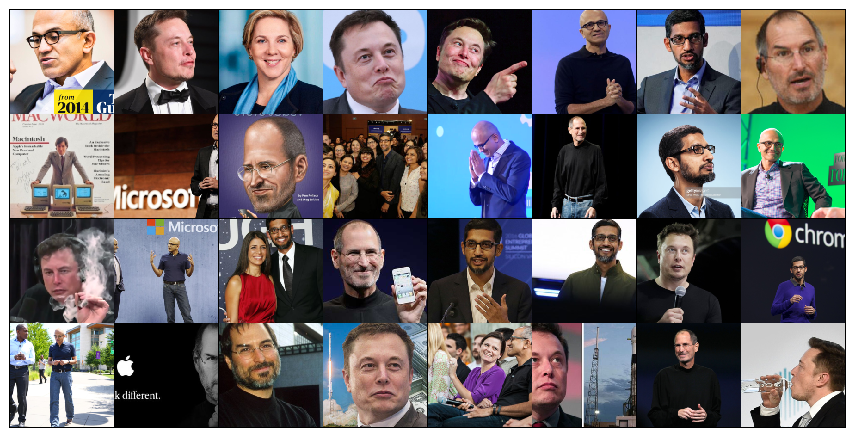

In [30]:
image_grid = utils.make_grid(images)
plot_image(image_grid, figsize=(15,15))

### 4. Prepare training dataset

In [31]:
transformation = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}


In [32]:
dataset = {x: datasets.ImageFolder(os.path.join(root_folder, x), transformation[x]) for x in ['train', 'valid']}
loader = {x: torch.utils.data.DataLoader(dataset[x], batch_size=32, shuffle=True, num_workers=4) for x in ['train', 'valid']}

dataset_size = {x: len(dataset[x]) for x in ['train', 'valid']}
class_names = dataset['train'].classes

In [33]:
dataset_size

{'train': 427, 'valid': 431}

In [34]:
class_names

['Elon Musk', 'Satya Nadella', 'Steve Jobs', 'Sundar Pichai']

### 5. Classify with original renset

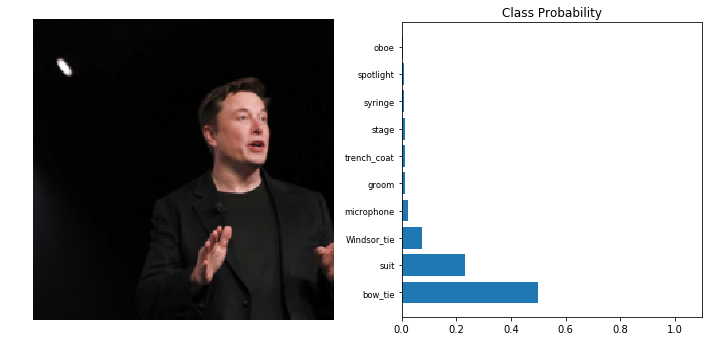

In [35]:
plot_classify(dataset['valid'][4][0], resnet18, topn=10, category_names=get_imagenet_category_names())

---

## Finetune resnet
We will use pretrained model on top of which we will place small classification feed forward network. Then we will train this whole architecture in 2 steps:   

1) fix of Resnet pretrained weights and tain just our simple added classifier     
2) use smaller learning rate and adjust also top layers of Resnet


### Setup model

In [36]:
from torch import nn, optim

In [37]:
output_size = len(dataset['train'].classes)
output_size

4

In [38]:
resnet18 = models.resnet18(pretrained=True)

In [39]:
resnet18.fc = torch.nn.Sequential(
    torch.nn.Linear(512, output_size),
    torch.nn.Softmax(dim=1))

loss_fce = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.fc.parameters())

### Basic finetuning of last layers

In [40]:
for param in resnet18.parameters():
    param.requires_grad = False

In [41]:
for param in resnet18.fc.parameters():
    param.requires_grad = True

In [42]:
model = resnet18

In [43]:
def get_valid_acc_and_loss(model, loss_fce, valid_loader):
    accuracy = 0
    loss = 0
    was_training = model.training
    model.eval()
    
    for images, labels in valid_loader:
        predictions = model(images)
        accuracy += (predictions.argmax(dim=1) == labels).type(torch.FloatTensor).mean().item() 
        loss += loss_fce(predictions, labels).item()
    
    model.train(mode=was_training)
    return accuracy / len(valid_loader) * 100, loss / len(valid_loader)

In [44]:
from collections import deque

# Initial params setup.
epochs = 20
report_period = 3
batch_iteration = 0

# Storing of some data.
train_leak_loss = deque(maxlen=report_period)
train_loss_history = []
valid_loss_history = []
valid_acc_history = []

In [52]:
for epoch in range(epochs):
    # Setup net to train mode and go through one epoch.
    model.train()
    for images, labels in loader['train']:
        batch_iteration += 1
        
        # Training net on one batch.
        optimizer.zero_grad()
        predictions = model.forward(images)
        loss = loss_fce(predictions, labels)
        loss.backward()
        optimizer.step()
        
        train_leak_loss.append(loss.item())
        # In case we should report, lets make validation on valid set.
        if batch_iteration % report_period == 0:
            model.eval()
            # We don't want to collect info for gradients from here.
            with torch.no_grad():
                valid_accuracy, valid_loss = get_valid_acc_and_loss(model, loss_fce, loader['valid'])
                
            print(f'Epoch: {epoch+1}/{epochs}.. ',
                  f"Train Loss: {round(np.mean(train_leak_loss), 2)}.. ",
                  f"Valid Loss: {round(valid_loss, 2)}.. ",
                  f"Valid Acc: {round(valid_accuracy, 2)}%")
            
            train_loss_history.append(np.mean(train_leak_loss))
            valid_loss_history.append(valid_loss)
            valid_acc_history.append(valid_accuracy)
                        
            model.train()

Epoch: 1/5..  Train Loss: 1.04..  Valid Loss: 0.99..  Valid Acc: 79.32%
Epoch: 1/5..  Train Loss: 1.08..  Valid Loss: 0.96..  Valid Acc: 81.38%
Epoch: 1/5..  Train Loss: 0.99..  Valid Loss: 0.94..  Valid Acc: 83.45%
Epoch: 1/5..  Train Loss: 0.98..  Valid Loss: 0.93..  Valid Acc: 83.2%
Epoch: 1/5..  Train Loss: 1.01..  Valid Loss: 0.94..  Valid Acc: 82.47%
Epoch: 2/5..  Train Loss: 0.9..  Valid Loss: 0.93..  Valid Acc: 82.25%
Epoch: 2/5..  Train Loss: 0.95..  Valid Loss: 0.92..  Valid Acc: 83.14%
Epoch: 2/5..  Train Loss: 0.95..  Valid Loss: 0.91..  Valid Acc: 84.54%
Epoch: 2/5..  Train Loss: 0.97..  Valid Loss: 0.91..  Valid Acc: 84.96%
Epoch: 3/5..  Train Loss: 0.95..  Valid Loss: 0.9..  Valid Acc: 86.1%
Epoch: 3/5..  Train Loss: 0.91..  Valid Loss: 0.9..  Valid Acc: 85.18%
Epoch: 3/5..  Train Loss: 0.91..  Valid Loss: 0.89..  Valid Acc: 85.43%
Epoch: 3/5..  Train Loss: 0.92..  Valid Loss: 0.88..  Valid Acc: 86.07%
Epoch: 3/5..  Train Loss: 0.9..  Valid Loss: 0.88..  Valid Acc: 88.33

### Extra finetuning of resnet layer4
Nice reading about advanced strategies for setup of lr here: ***https://www.jeremyjordan.me/nn-learning-rate/***

 - let's setup as trainable parameters of last layer of resnet model
 - make learning rate 10 times smaller
 - re-run previous training cell with adjusted setup

In [46]:
optimizer.param_groups[0]['lr']

0.001

In [47]:
optimizer.param_groups[0]['params']

[Parameter containing:
 tensor([[ 0.0576, -0.0445,  0.0095,  ..., -0.0259,  0.0149,  0.0170],
         [-0.1216,  0.0436,  0.0689,  ...,  0.0087,  0.0260,  0.0194],
         [-0.0106, -0.0045, -0.0128,  ...,  0.0020, -0.0917, -0.0672],
         [-0.0644, -0.0191, -0.0012,  ..., -0.0074, -0.0014, -0.0336]],
        requires_grad=True), Parameter containing:
 tensor([-0.0255,  0.0221, -0.0388, -0.0181], requires_grad=True)]

In [48]:
epochs=5

In [49]:
for param in model.layer4.parameters():
    param.requires_grad = True

In [50]:
optimizer.param_groups[0]['params'] = optimizer.param_groups[0]['params'] + list(model.layer4.parameters())

In [51]:
optimizer.param_groups[0]['lr'] = 0.0001

**Go back and re-run training cell**

### After all training save the model

In [62]:
training_state = {
    'optimizer': optimizer.param_groups,
    'net': model.state_dict()
}

In [63]:
torch.save(training_state, './models/finetuned_resnet.pth')

### Visualize progress of training

In [59]:
import matplotlib.pylab as plt 

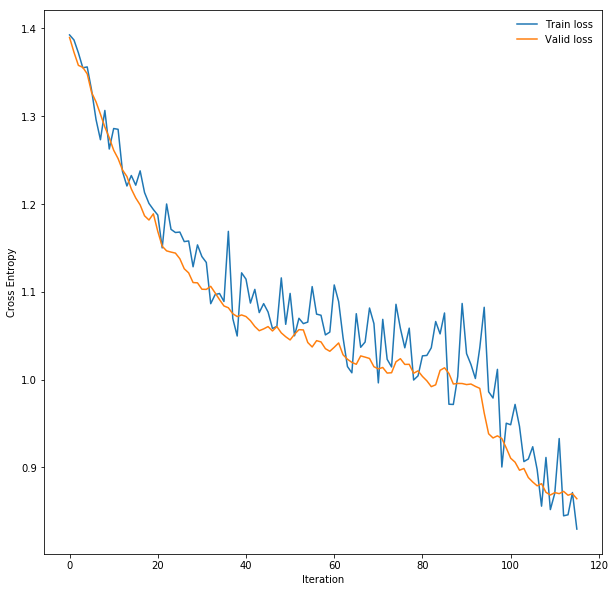

In [60]:
fig = plt.figure(figsize=(10, 10))
ax = plt.gca()
ax.set_xlabel('Iteration')
ax.set_ylabel('Cross Entropy')
plt.plot(train_loss_history, label='Train loss')
plt.plot(valid_loss_history, label='Valid loss')
plt.legend(frameon=False)

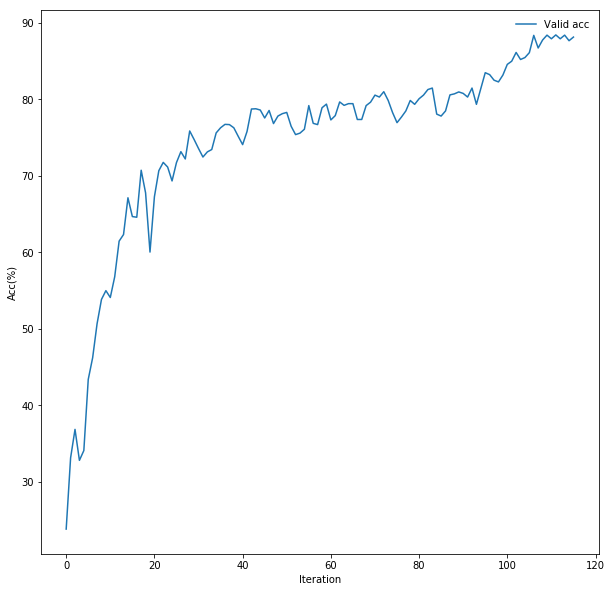

In [61]:
fig = plt.figure(figsize=(10, 10))
plt.plot(valid_acc_history, label='Valid acc')
ax = plt.gca()
ax.set_xlabel('Iteration')
ax.set_ylabel('Acc(%)')
plt.legend(frameon=False)

---

## Results evaluation

In [64]:
info = model.eval()

### View single images and predictions

In [65]:
from image_processing_workshop.visual import plot_classify, plot_image

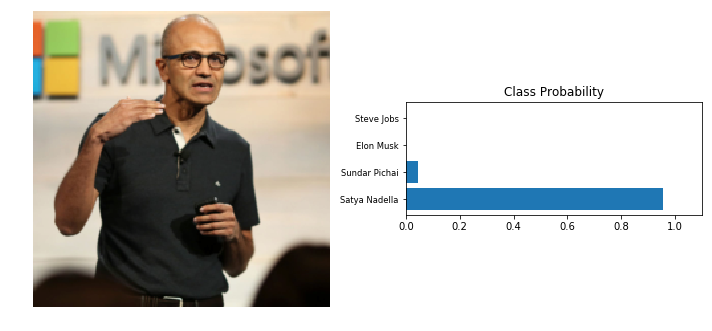

In [67]:
plot_classify(dataset['valid'][120][0], model, category_names=class_names)

### Load reuslts to pandas df

In [68]:
from image_processing_workshop.eval import get_results_df
from image_processing_workshop.visual import plot_df_examples

In [69]:
df = get_results_df(model, loader['valid'])
df.head(10)

label_class_name  label_class_score predicted_class_name_top1  \
0       Steve Jobs           0.999437                Steve Jobs   
1        Elon Musk           0.999352                 Elon Musk   
2       Steve Jobs           0.267566                 Elon Musk   
3    Satya Nadella           0.999052             Satya Nadella   
4       Steve Jobs           0.922455                Steve Jobs   
5    Sundar Pichai           0.112052             Satya Nadella   
6        Elon Musk           0.978064                 Elon Musk   
7    Sundar Pichai           0.143306             Satya Nadella   
8    Sundar Pichai           0.971451             Sundar Pichai   
9    Sundar Pichai           0.069431                Steve Jobs   

   predicted_class_score_top1  \
0                    0.999437   
1                    0.999352   
2                    0.730335   
3                    0.999052   
4                    0.922455   
5                    0.843958   
6                    0.978064   
7                    0.856606   
8                    0.971451   
9                    0.928105   

                                               image  
0  [[[-2.1007792949676514, -2.1007792949676514, -...  
1  [[[-0.0800582766532898, -0.18280678987503052, ...  
2  [[[-2.0836544036865234, -2.032280206680298, -2...  
3  [[[0.6391814351081848, 0.6734309792518616, 0.6...  
4  [[[0.1083141341805458, 0.17681314051151276, 0....  
5  [[[0.844678521156311, 0.844678521156311, 0.896...  
6  [[[0.09118937700986862, 0.039814990013837814, ...  
7  [[[-0.13143253326416016, -0.0800582766532898, ...  
8  [[[-1.004794955253601, -1.004794955253601, -0....  
9  [[[-2.0665297508239746, -2.0494048595428467, -...

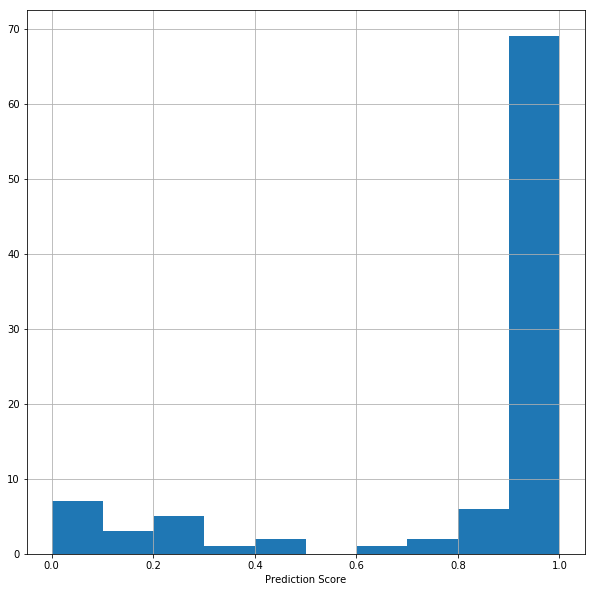

In [70]:
fig = plt.figure(figsize=(10, 10))
ax = plt.gca()
ax.set_xlabel('Prediction Score')
df[df.label_class_name=='Steve Jobs'].label_class_score.hist(ax=ax)

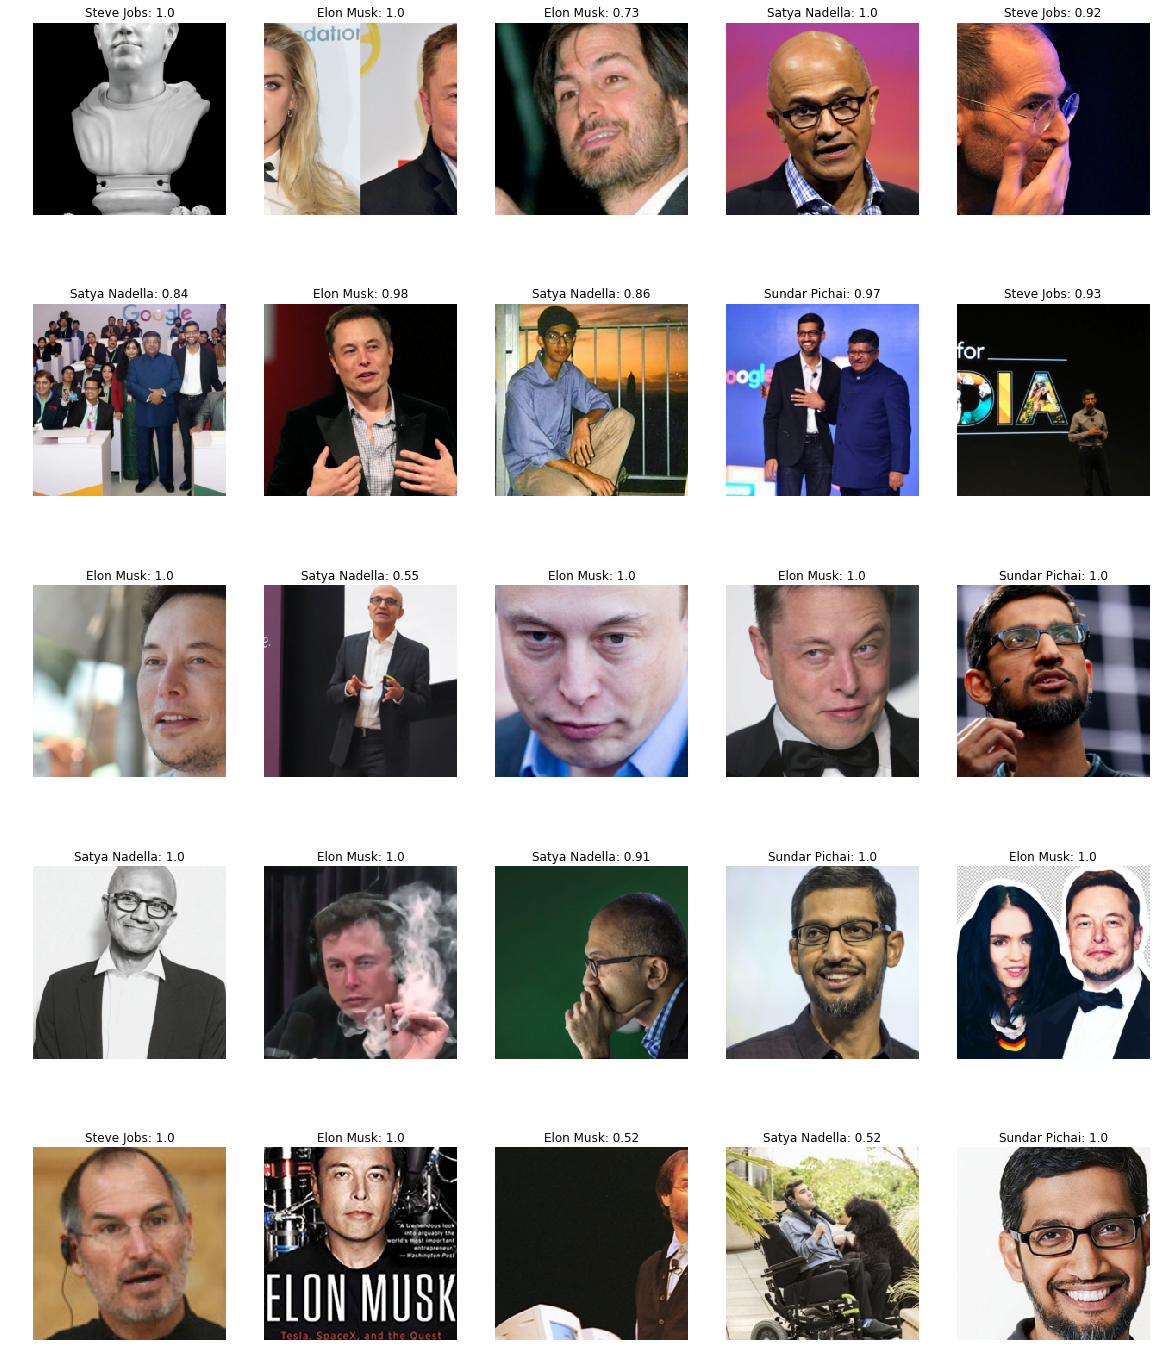

In [71]:
plot_df_examples(df.iloc[:25])

### Overall Recall and Precision


In [72]:
from image_processing_workshop.eval import get_rec_prec

In [73]:
get_rec_prec(df, class_names)

class_name  recall  precision
0      Elon Musk   96.46      86.51
1  Satya Nadella   88.46      86.79
2     Steve Jobs   82.29      90.80
3  Sundar Pichai   86.44      91.07

### Accuracy

In [74]:
from image_processing_workshop.eval import get_accuracy

In [75]:
get_accuracy(df)

88.63

### False Positives

In [76]:
from image_processing_workshop.eval import get_false_positives

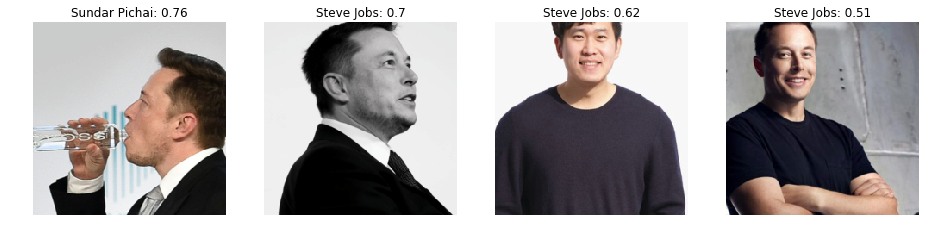

In [79]:
fp = get_false_positives(df, label_class_name='Elon Musk')
plot_df_examples(fp)

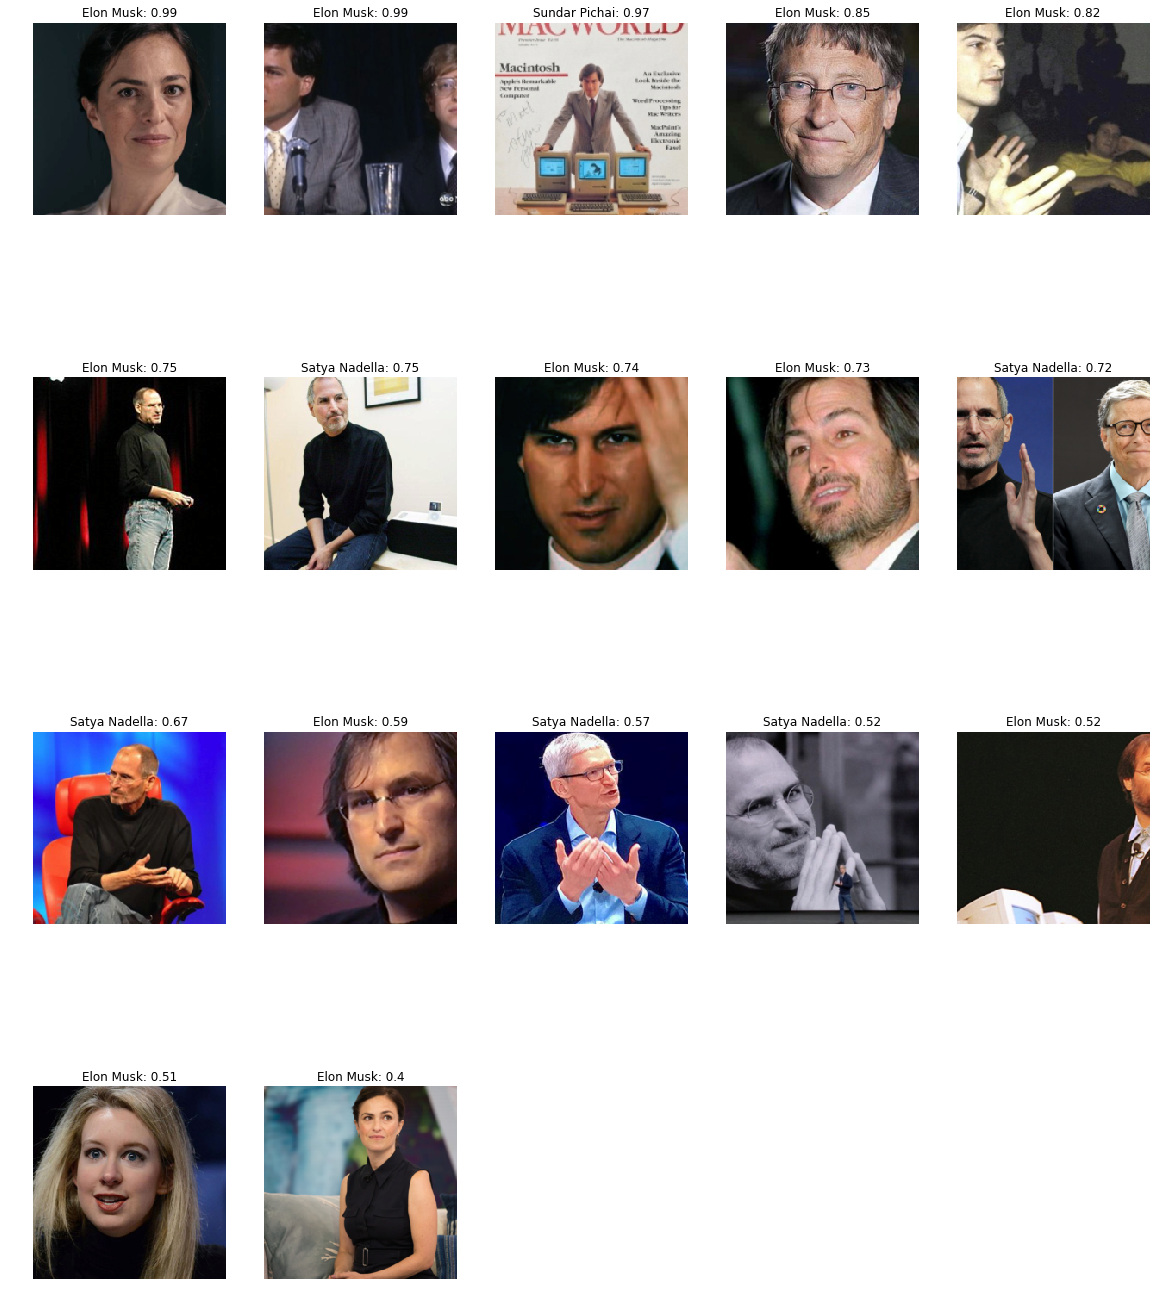

In [82]:
fp = get_false_positives(df, label_class_name='Steve Jobs')
plot_df_examples(fp)

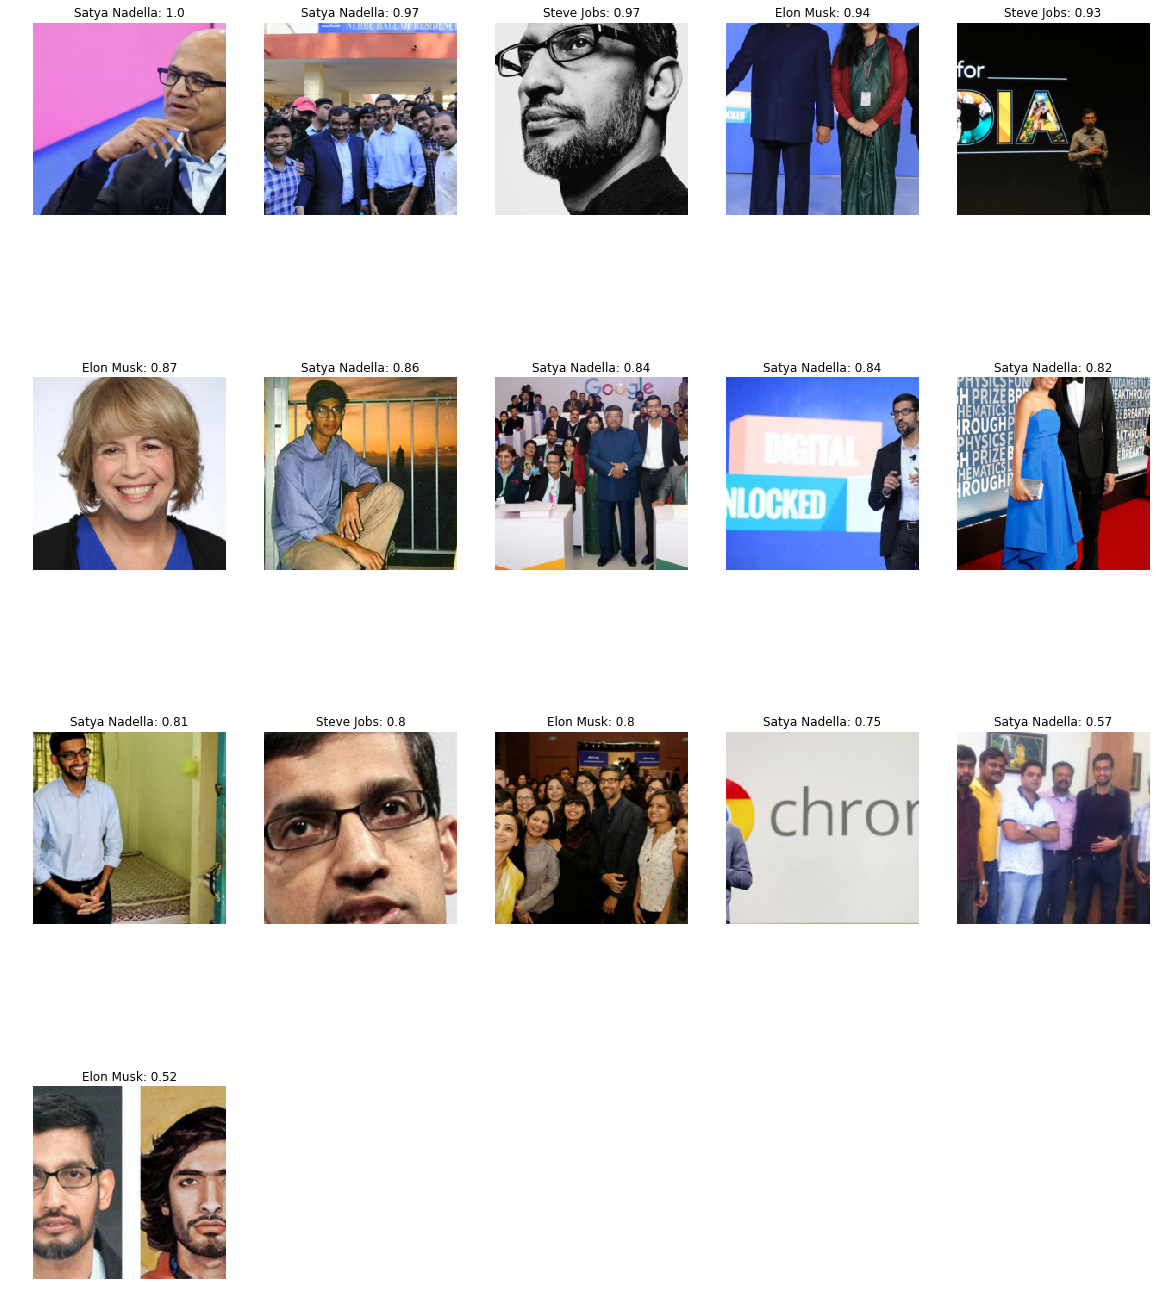

In [84]:
fp = get_false_positives(df, label_class_name='Sundar Pichai')
plot_df_examples(fp)

### Confusion Matrix

In [80]:
from image_processing_workshop.visual import plot_coocurance_matrix

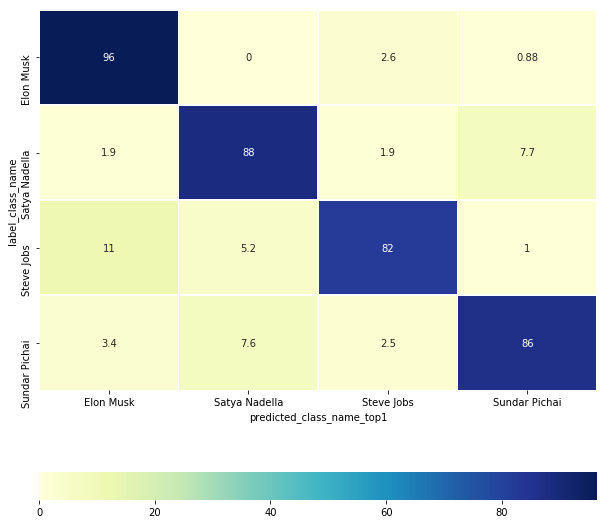

In [81]:
plot_coocurance_matrix(df, use_log=False)